[Epoch 0/500] [Batch 0/3] [D loss: 0.6828] [G loss: 1.8220]
[Epoch 1/500] [Batch 0/3] [D loss: 1.0771] [G loss: 1.9947]
[Epoch 2/500] [Batch 0/3] [D loss: 0.5623] [G loss: 3.3692]
[Epoch 3/500] [Batch 0/3] [D loss: 0.4056] [G loss: 3.8513]
[Epoch 4/500] [Batch 0/3] [D loss: 0.2884] [G loss: 4.1247]
[Epoch 5/500] [Batch 0/3] [D loss: 0.2669] [G loss: 4.5456]
[Epoch 6/500] [Batch 0/3] [D loss: 0.3141] [G loss: 4.7349]
[Epoch 7/500] [Batch 0/3] [D loss: 0.3170] [G loss: 4.9346]
[Epoch 8/500] [Batch 0/3] [D loss: 0.3144] [G loss: 4.5941]
[Epoch 9/500] [Batch 0/3] [D loss: 0.4107] [G loss: 5.4676]
[Epoch 10/500] [Batch 0/3] [D loss: 0.3065] [G loss: 5.4102]
[Epoch 11/500] [Batch 0/3] [D loss: 0.3021] [G loss: 5.8413]
[Epoch 12/500] [Batch 0/3] [D loss: 0.2331] [G loss: 5.2626]
[Epoch 13/500] [Batch 0/3] [D loss: 0.2665] [G loss: 4.9882]
[Epoch 14/500] [Batch 0/3] [D loss: 0.3396] [G loss: 6.6582]
[Epoch 15/500] [Batch 0/3] [D loss: 0.2207] [G loss: 5.0034]
[Epoch 16/500] [Batch 0/3] [D loss

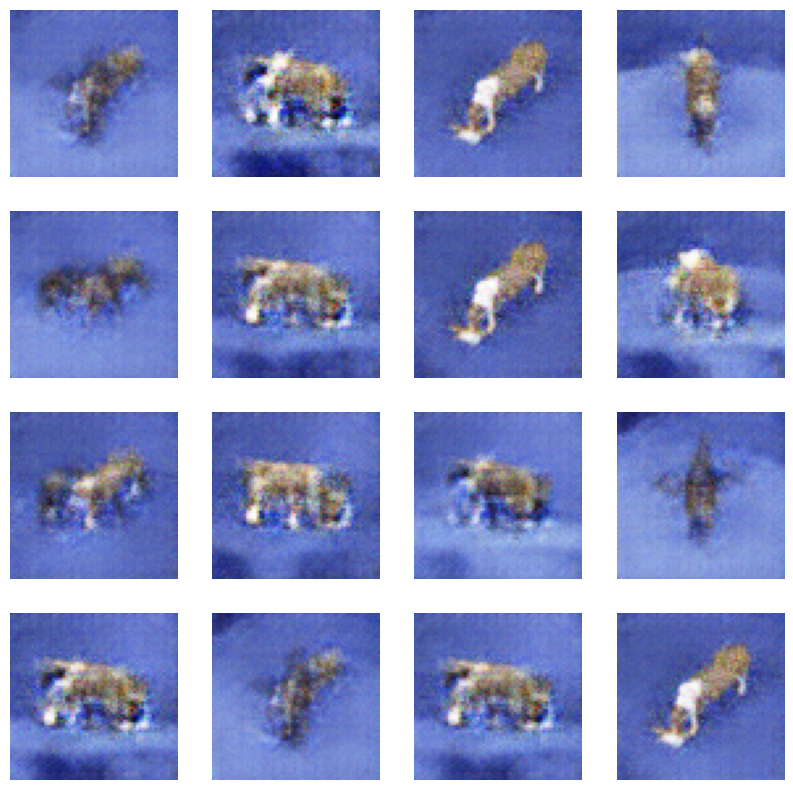

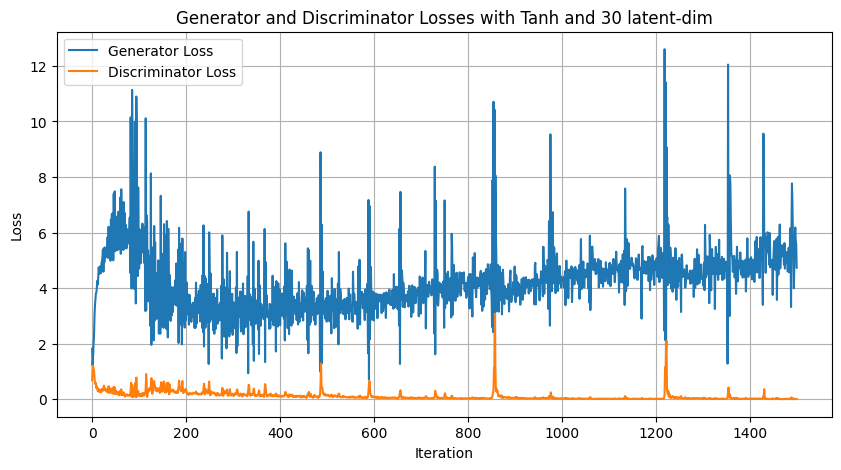

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preparation
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64 for GAN
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

train_dataset = datasets.ImageFolder(root='dataset/Train', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# ----------------------------
# Generator Network
# ----------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, channels):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. 64*8 x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. 64*4 x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. 64*2 x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. channels x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# ----------------------------
# Discriminator Network
# ----------------------------
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is channels x 64 x 64
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*2 x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*4 x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*8 x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# ----------------------------
# Training Setup
# ----------------------------
latent_dim = 30
channels = 3  # RGB images

generator = Generator(latent_dim, channels).to(device)
discriminator = Discriminator(channels).to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

num_epochs = 500
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)  # For generating samples

# Lists to store losses
G_losses = []
D_losses = []

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Adversarial ground truths
        valid = torch.ones(batch_size, device=device)
        fake = torch.zeros(batch_size, device=device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)

        # Generate a batch of images
        fake_images = generator(z).detach()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(discriminator(real_images), valid)
        fake_loss = criterion(discriminator(fake_images), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        fake_images = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion(discriminator(fake_images), valid)

        g_loss.backward()
        optimizer_G.step()

        # Save losses for plotting
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

print("Training complete.")

# ----------------------------
# Print Generated Images
# ----------------------------
with torch.no_grad():
    fake_images = generator(fixed_noise).detach().cpu()

# Plot a few generated images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    img = fake_images[i].numpy().transpose(1, 2, 0)
    img = (img * 0.5) + 0.5  # Unnormalize
    ax.imshow(img)
    ax.axis('off')
plt.show()

# ----------------------------
# Plot Losses
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses with Tanh and 30 latent-dim')
plt.legend()
plt.grid(True)
plt.show()

[Epoch 0/500] [Batch 0/3] [D loss: 0.7187] [G loss: 1.7522]
[Epoch 1/500] [Batch 0/3] [D loss: 0.9803] [G loss: 2.0654]
[Epoch 2/500] [Batch 0/3] [D loss: 0.6939] [G loss: 2.9837]
[Epoch 3/500] [Batch 0/3] [D loss: 0.5475] [G loss: 3.5668]
[Epoch 4/500] [Batch 0/3] [D loss: 0.3072] [G loss: 4.1801]
[Epoch 5/500] [Batch 0/3] [D loss: 0.2840] [G loss: 4.2764]
[Epoch 6/500] [Batch 0/3] [D loss: 0.3932] [G loss: 4.3906]
[Epoch 7/500] [Batch 0/3] [D loss: 0.3342] [G loss: 4.4875]
[Epoch 8/500] [Batch 0/3] [D loss: 0.3561] [G loss: 4.7997]
[Epoch 9/500] [Batch 0/3] [D loss: 0.2746] [G loss: 5.0680]
[Epoch 10/500] [Batch 0/3] [D loss: 0.2361] [G loss: 4.9915]
[Epoch 11/500] [Batch 0/3] [D loss: 0.3307] [G loss: 5.2301]
[Epoch 12/500] [Batch 0/3] [D loss: 0.3598] [G loss: 5.2993]
[Epoch 13/500] [Batch 0/3] [D loss: 0.4732] [G loss: 7.0772]
[Epoch 14/500] [Batch 0/3] [D loss: 0.2499] [G loss: 6.0272]
[Epoch 15/500] [Batch 0/3] [D loss: 0.1815] [G loss: 5.6280]
[Epoch 16/500] [Batch 0/3] [D loss

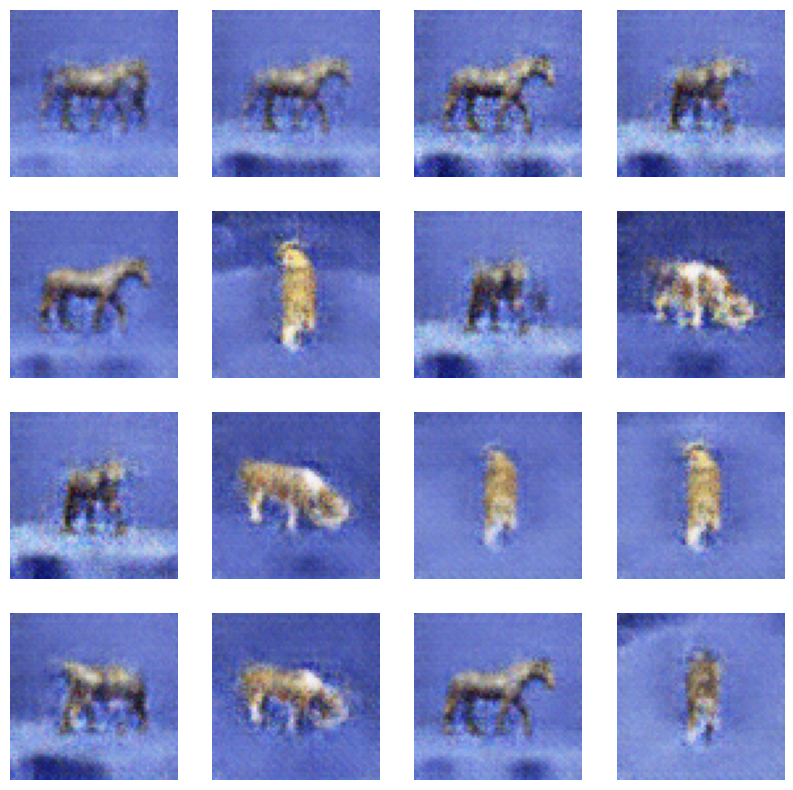

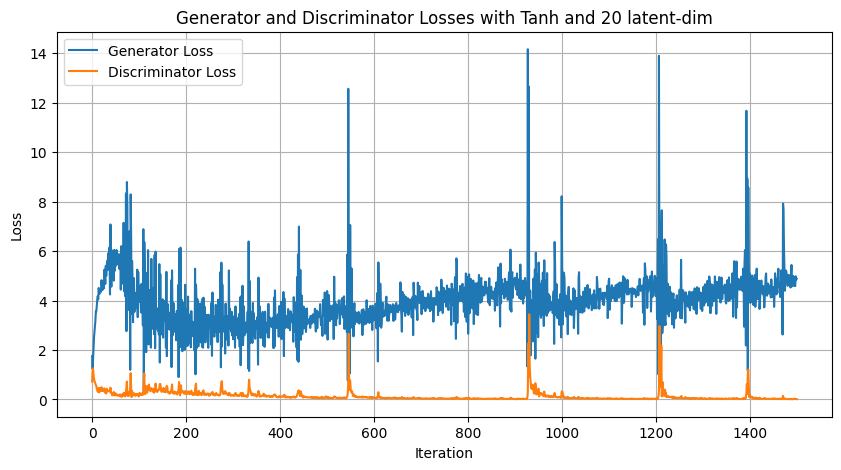

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preparation
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64 for GAN
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

train_dataset = datasets.ImageFolder(root='dataset/Train', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# ----------------------------
# Generator Network
# ----------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, channels):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. 64*8 x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. 64*4 x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. 64*2 x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. channels x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# ----------------------------
# Discriminator Network
# ----------------------------
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is channels x 64 x 64
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*2 x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*4 x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*8 x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# ----------------------------
# Training Setup
# ----------------------------
latent_dim = 20
channels = 3  # RGB images

generator = Generator(latent_dim, channels).to(device)
discriminator = Discriminator(channels).to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

num_epochs = 500
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)  # For generating samples

# Lists to store losses
G_losses = []
D_losses = []

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Adversarial ground truths
        valid = torch.ones(batch_size, device=device)
        fake = torch.zeros(batch_size, device=device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)

        # Generate a batch of images
        fake_images = generator(z).detach()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(discriminator(real_images), valid)
        fake_loss = criterion(discriminator(fake_images), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        fake_images = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion(discriminator(fake_images), valid)

        g_loss.backward()
        optimizer_G.step()

        # Save losses for plotting
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

print("Training complete.")

# ----------------------------
# Print Generated Images
# ----------------------------
with torch.no_grad():
    fake_images = generator(fixed_noise).detach().cpu()

# Plot a few generated images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    img = fake_images[i].numpy().transpose(1, 2, 0)
    img = (img * 0.5) + 0.5  # Unnormalize
    ax.imshow(img)
    ax.axis('off')
plt.show()

# ----------------------------
# Plot Losses
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses with Tanh and 20 latent-dim')
plt.legend()
plt.grid(True)
plt.show()

[Epoch 0/500] [Batch 0/3] [D loss: 0.7319] [G loss: 2.0105]
[Epoch 1/500] [Batch 0/3] [D loss: 0.2771] [G loss: 3.0699]
[Epoch 2/500] [Batch 0/3] [D loss: 0.1622] [G loss: 3.8589]
[Epoch 3/500] [Batch 0/3] [D loss: 0.1715] [G loss: 4.6189]
[Epoch 4/500] [Batch 0/3] [D loss: 0.1218] [G loss: 4.9548]
[Epoch 5/500] [Batch 0/3] [D loss: 0.0644] [G loss: 4.8256]
[Epoch 6/500] [Batch 0/3] [D loss: 0.1162] [G loss: 6.1055]
[Epoch 7/500] [Batch 0/3] [D loss: 0.0547] [G loss: 5.4864]
[Epoch 8/500] [Batch 0/3] [D loss: 0.0659] [G loss: 5.6582]
[Epoch 9/500] [Batch 0/3] [D loss: 0.0736] [G loss: 7.2507]
[Epoch 10/500] [Batch 0/3] [D loss: 0.1456] [G loss: 5.1937]
[Epoch 11/500] [Batch 0/3] [D loss: 0.0214] [G loss: 6.6464]
[Epoch 12/500] [Batch 0/3] [D loss: 0.1122] [G loss: 2.2797]
[Epoch 13/500] [Batch 0/3] [D loss: 0.0030] [G loss: 3.7829]
[Epoch 14/500] [Batch 0/3] [D loss: 0.0551] [G loss: 7.0354]
[Epoch 15/500] [Batch 0/3] [D loss: 0.4089] [G loss: 4.2358]
[Epoch 16/500] [Batch 0/3] [D loss

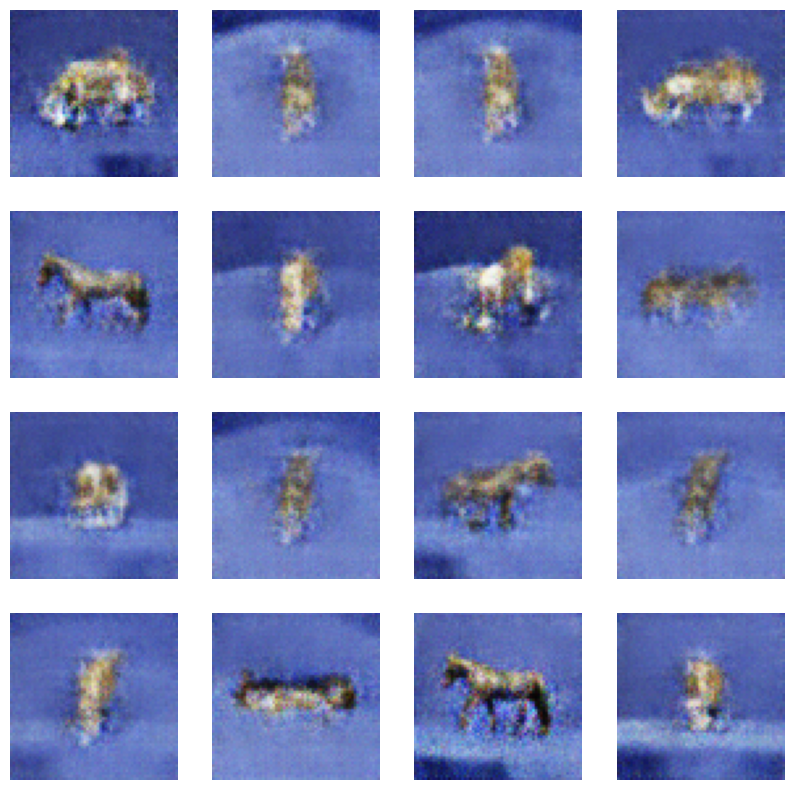

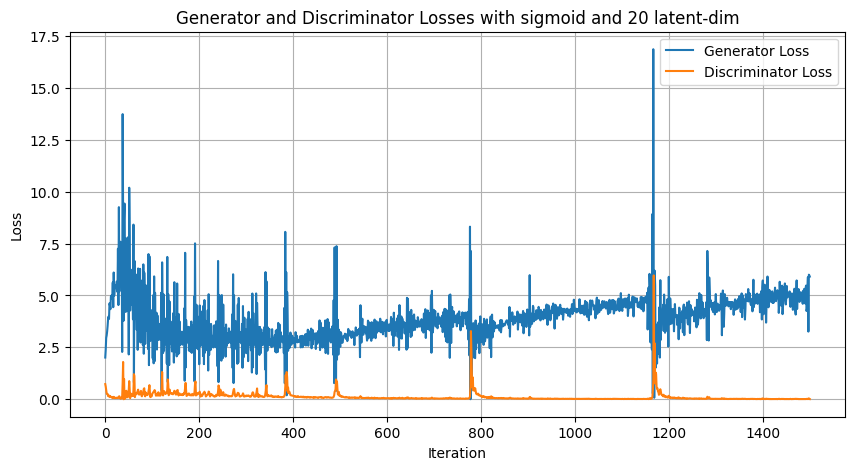

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preparation
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64 for GAN
    transforms.ToTensor()
    # Removed normalization
])

train_dataset = datasets.ImageFolder(root='dataset/Train', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# ----------------------------
# Generator Network
# ----------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, channels):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. 64*8 x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. 64*4 x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. 64*2 x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Sigmoid()  # Using Sigmoid instead of Tanh
            # state size. channels x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# ----------------------------
# Discriminator Network
# ----------------------------
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is channels x 64 x 64
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*2 x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*4 x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*8 x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# ----------------------------
# Training Setup
# ----------------------------
latent_dim = 20
channels = 3  # RGB images

generator = Generator(latent_dim, channels).to(device)
discriminator = Discriminator(channels).to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

num_epochs = 500
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)  # For generating samples

# Lists to store losses
G_losses = []
D_losses = []

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Adversarial ground truths
        valid = torch.ones(batch_size, device=device)
        fake = torch.zeros(batch_size, device=device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)

        # Generate a batch of images
        fake_images = generator(z).detach()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(discriminator(real_images), valid)
        fake_loss = criterion(discriminator(fake_images), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        fake_images = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion(discriminator(fake_images), valid)

        g_loss.backward()
        optimizer_G.step()

        # Save losses for plotting
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

print("Training complete.")

# ----------------------------
# Print Generated Images
# ----------------------------
with torch.no_grad():
    fake_images = generator(fixed_noise).detach().cpu()

# Plot a few generated images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    img = fake_images[i].numpy().transpose(1, 2, 0)
    img = img  # Removed unnormalization
    ax.imshow(img)
    ax.axis('off')
plt.show()

# ----------------------------
# Plot Losses
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses with sigmoid and 20 latent-dim')
plt.legend()
plt.grid(True)
plt.show()

[Epoch 0/500] [Batch 0/3] [D loss: 0.7263] [G loss: 1.2903]
[Epoch 1/500] [Batch 0/3] [D loss: 0.3175] [G loss: 3.3195]
[Epoch 2/500] [Batch 0/3] [D loss: 0.1959] [G loss: 3.5958]
[Epoch 3/500] [Batch 0/3] [D loss: 0.1822] [G loss: 4.2722]
[Epoch 4/500] [Batch 0/3] [D loss: 0.1457] [G loss: 4.5321]
[Epoch 5/500] [Batch 0/3] [D loss: 0.1110] [G loss: 4.7726]
[Epoch 6/500] [Batch 0/3] [D loss: 0.0983] [G loss: 5.2182]
[Epoch 7/500] [Batch 0/3] [D loss: 0.1108] [G loss: 5.7963]
[Epoch 8/500] [Batch 0/3] [D loss: 0.1186] [G loss: 5.2149]
[Epoch 9/500] [Batch 0/3] [D loss: 0.1202] [G loss: 5.0696]
[Epoch 10/500] [Batch 0/3] [D loss: 0.1039] [G loss: 7.0240]
[Epoch 11/500] [Batch 0/3] [D loss: 0.1169] [G loss: 8.3323]
[Epoch 12/500] [Batch 0/3] [D loss: 0.1292] [G loss: 7.6233]
[Epoch 13/500] [Batch 0/3] [D loss: 0.1320] [G loss: 6.9194]
[Epoch 14/500] [Batch 0/3] [D loss: 0.8571] [G loss: 3.3536]
[Epoch 15/500] [Batch 0/3] [D loss: 0.0629] [G loss: 4.7961]
[Epoch 16/500] [Batch 0/3] [D loss

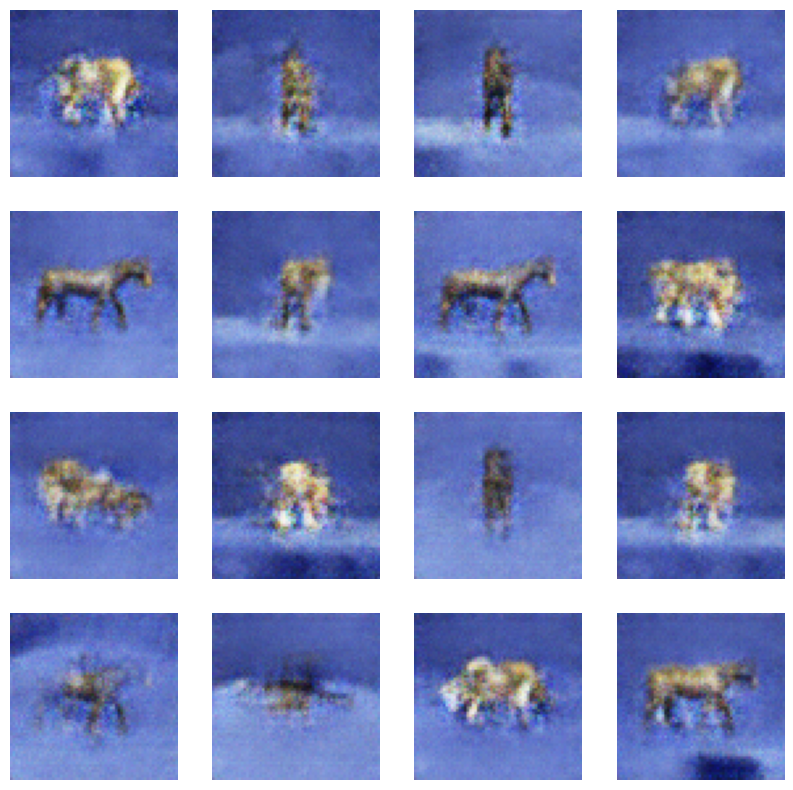

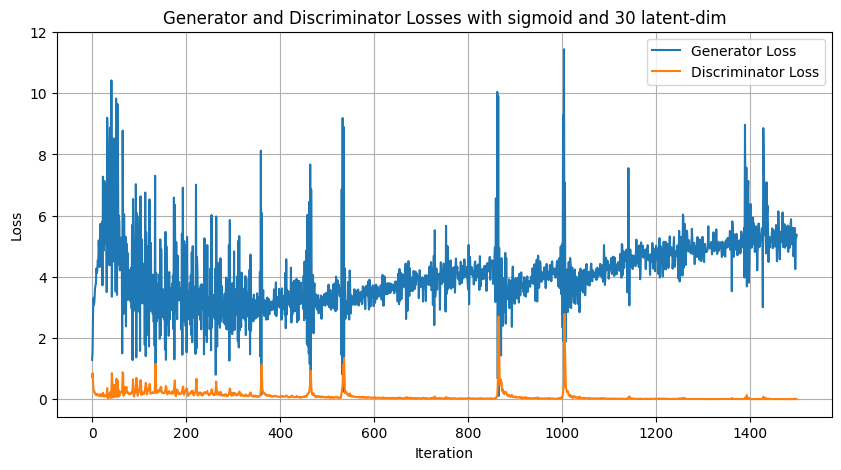

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preparation
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64 for GAN
    transforms.ToTensor()
    # Removed normalization
])

train_dataset = datasets.ImageFolder(root='dataset/Train', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# ----------------------------
# Generator Network
# ----------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, channels):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. 64*8 x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. 64*4 x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. 64*2 x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Sigmoid()  # Using Sigmoid instead of Tanh
            # state size. channels x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# ----------------------------
# Discriminator Network
# ----------------------------
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is channels x 64 x 64
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*2 x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*4 x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*8 x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# ----------------------------
# Training Setup
# ----------------------------
latent_dim = 30
channels = 3  # RGB images

generator = Generator(latent_dim, channels).to(device)
discriminator = Discriminator(channels).to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

num_epochs = 500
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)  # For generating samples

# Lists to store losses
G_losses = []
D_losses = []

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Adversarial ground truths
        valid = torch.ones(batch_size, device=device)
        fake = torch.zeros(batch_size, device=device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)

        # Generate a batch of images
        fake_images = generator(z).detach()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(discriminator(real_images), valid)
        fake_loss = criterion(discriminator(fake_images), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        fake_images = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion(discriminator(fake_images), valid)

        g_loss.backward()
        optimizer_G.step()

        # Save losses for plotting
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

print("Training complete.")

# ----------------------------
# Print Generated Images
# ----------------------------
with torch.no_grad():
    fake_images = generator(fixed_noise).detach().cpu()

# Plot a few generated images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    img = fake_images[i].numpy().transpose(1, 2, 0)
    img = img  # Removed unnormalization
    ax.imshow(img)
    ax.axis('off')
plt.show()

# ----------------------------
# Plot Losses
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses with sigmoid and 30 latent-dim')
plt.legend()
plt.grid(True)
plt.show()